# Consegna del progetto per il Deblur di Immagini, di Apprendimento Automatico, dallo studente Giuseppe Forciniti ( Codice matricola 0001019464 ).

## Spiegherò il funzionamento del codice e ogni scelta nelle apposite celle di markdown.


### Import necessari

In [172]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt


### Qui viene caricato il dataset MNIST. Il set di dati è suddiviso in set di allenamento e set di test. Normalizzo i dati dell'immagine in un intervallo da 0 a 1 dividendoli per 255 (poiché i valori dei pixel vanno da 0 a 255). Questa normalizzazione aiuta la convergenza del processo di addestramento. Inoltre, converto i dati in float32 per compatibilità con il modello TensorFlow. Infine, divido i dati di addestramento in set di addestramento e di validazione (80% per l'addestramento e 20% per la validazione) per valutare le prestazioni del modello su dati non visti.


In [173]:
# Load del dataset MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Ridimensiona le immagini per adattarle ai requisiti di input delle reti neurali
train_images = (train_images/255.).astype(np.float32)
test_images = (test_images/255.).astype(np.float32)

# Split training data per la validazione
split = int(len(train_images) * 0.8)
x_train, x_valid = train_images[:split], train_images[split:]

### Questa cella definisce una funzione generatrice provvista dal professore.

In [174]:
# Generatore di immagini blurrate provveduto dal professore
def generator(dataset, batchsize, moves=10):
    while True:
        rand = np.random.randint(dataset.shape[0], size=batchsize)
        y_truth = dataset[rand]
        blurred = np.copy(y_truth)
        moving = tf.expand_dims(y_truth, axis=-1)

        for i in range(moves):
            moving = layers.RandomTranslation(0.07, 0.07, fill_mode='constant', interpolation='bilinear')(moving)
            blurred = blurred + tf.squeeze(moving)
        blurred = blurred / (moves + 1)
        yield (blurred, y_truth)


### La funzione residual_block definisce un componente chiave, per facilitare le strutture di rete più profonde, risolvendo il problema del vanishing gradient.


In [175]:
def residual_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    res = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        res = layers.BatchNormalization()(res)
    res = layers.Activation(activation)(res)
    res = layers.Conv2D(filters, kernel_size, padding='same')(res)
    if batch_norm:
        res = layers.BatchNormalization()(res)
    return layers.Add()([x, res])

### Qui definisco il nostro modello di rete neurale convoluzionale (CNN). Il modello è sequenziale e consiste in strati convoluzionali, max pooling, upsampling e infine di nuovo strati convoluzionali. Ogni strato convoluzionale è seguito da una funzione di attivazione "relu", che introduce la non linearità, consentendo al modello di apprendere pattern più complessi. La scelta di 64, 128 e 256 filtri negli strati convoluzionali si basa sulla pratica comune, prendendo specialmente spunto dalle U-Net. Il padding è impostato su "same" per mantenere le dimensioni spaziali dell'immagine dopo la convoluzione. I livelli di upsampling aumentano la risoluzione spaziale dell'output, fondamentale per la ricostruzione delle immagini sfocate. Infine, per l'output utilizzo una sigmoide in quanto è perfetta per la classificazione binaria, in quanto produrrà un punteggio di probabilità compreso tra 0 e 1.

In [176]:
# Definisco l'input
input_layer = layers.Input(shape=(28, 28, 1))

# Primo blocco convoluzionale
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Secondo blocco
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Terzo
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Blocco residuo
x = residual_block(x, 256)

# Upsampling
x = layers.UpSampling2D((2, 2))(x)

# Blocco di convoluzione finale
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
output_layer = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Creazione del modello
model = models.Model(inputs=input_layer, outputs=output_layer)

model.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_200 (Conv2D)         (None, 28, 28, 64)           640       ['input_21[0][0]']            
                                                                                                  
 batch_normalization_180 (B  (None, 28, 28, 64)           256       ['conv2d_200[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_201 (Conv2D)         (None, 28, 28, 64)           36928     ['batch_normalization_1

### In questa cella, compilo il modello con l'ottimizzatore Adam e l'errore quadratico medio (MSE) come loss function ( richiesto dal professore ). Adam è stato scelto per la sua efficacia nel gestire gradienti scarsi e nell'adattare il tasso di apprendimento durante l'addestramento, a vantaggio della convergenza. L'MSE è appropriato per compiti di regressione come il nostro, in cui l'obiettivo è minimizzare la differenza in pixel tra le immagini previste e quelle reali.


In [177]:
# Compilazione del modello
model.compile(optimizer='adam', loss='mean_squared_error')


### Le callback sono utilizzate per migliorare il processo di addestramento. `ModelCheckpoint` è usato per salvare il modello alle sue migliori prestazioni (cioè con la perdita di convalida più bassa), evitando di perdere i progressi in caso di interruzione dell'addestramento. `EarlyStopping` è utilizzato per interrompere l'addestramento se il modello non migliora per un determinato numero di epoche ('pazienza'). Questo aiuta a prevenire l'overfitting e a ridurre gli sprechi computazionali.


In [178]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("deblur_model_final.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


### La dimensione del batch è impostata a 32, che rappresenta un equilibrio tra efficienza computazionale e prestazioni del modello, oltre ad essere il valore standard per training di CNN. I passi per epoca e i passi di validazione sono calcolati in base alla dimensione degli insiemi di addestramento e di validazione, assicurando che il modello veda tutti gli esempi di addestramento in ogni epoca. Si avvia l'addestramento del modello utilizzando un for loop, in cui inserisco i generatori di addestramento e validazione che chiamano la funzione `generator` con un numero adeguato di campioni, basato su `steps_per_epoch` e `batch_size`, e il metodo fit. Questo per evitare un errore dovuto a "RandomTranslation" della funzione di generazione, e inoltre rende il training molto piu veloce. La scelta del valore 10 nel for loop, che implica 10 epoch totali, deriva dal fatto che bilancia bene il tempo sufficiente di addestramento con quello necessario per evitare l'overfitting. Le callback definite in precedenza sono incluse anche qui per monitorare e salvare il modello migliore.

In [179]:
batch_size = 32


# Calcolo degli step
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_valid) // batch_size

# Training loop
for i in range(10):
    print(f"Epoch: {i + 1}/{10}")
    train_gen, train_gen_y = next(generator(x_train, steps_per_epoch * batch_size))
    val_gen = next(generator(x_valid, steps_per_epoch * batch_size))

    # Training del modello
    history = model.fit(
        x = train_gen,
        y = train_gen_y,
        steps_per_epoch=steps_per_epoch,
        epochs=1,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=[checkpoint_cb, early_stopping_cb]
    )


Epoch: 1/10
1500/1500 [==============================] - 54s 32ms/step - loss: 0.0172 - val_loss: 0.0080
Epoch: 2/10
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch: 3/10
1500/1500 [==============================] - 46s 30ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch: 4/10
1500/1500 [==============================] - 48s 32ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch: 5/10
1500/1500 [==============================] - 46s 31ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch: 6/10
1500/1500 [==============================] - 46s 30ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch: 7/10
1500/1500 [==============================] - 46s 30ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch: 8/10
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch: 9/10
1500/1500 [==============================] - 46s 30ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch: 10/10
1500/1500 [==============================]

### Infine, valuto le prestazioni del modello. Per prima cosa mi assicuro che l'insieme di convalida sia sufficientemente grande (almeno 10.000 immagini) per una valutazione significativa. Utilizzo quindi il `generatore` per creare batch di dati di convalida e valuto il modello 10 volte per ottenere una stima più affidabile delle sue prestazioni ( richiesto dal professore ).

In [180]:
# Mi assicuro della grandezza del validation set
assert len(x_valid) >= 10000, "Il validation set ha meno di 10000 immagini"

# Aggiustare i passi per la valutazione per coprire 10.000 immagini
evaluation_steps = 10000 // batch_size

# Valuta il modello per 10 round
mse_scores = []
for i in range(10):
    val_gen = generator(x_valid, batch_size)
    mse = model.evaluate(val_gen, steps=evaluation_steps)
    mse_scores.append(mse)

# Calcola la media e la deviazione standard
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"MSE medio su 10 round: {mean_mse}")
print(f"Deviazione standard dell'MSE su 10 rounds: {std_mse}")


312/312 [==============================] - 42s 134ms/step - loss: 0.0037
MSE medio su 10 round: 0.0035747344838455318
Deviazione standard dell'MSE su 10 rounds: 4.393102881446634e-05


### Plot dei risultati

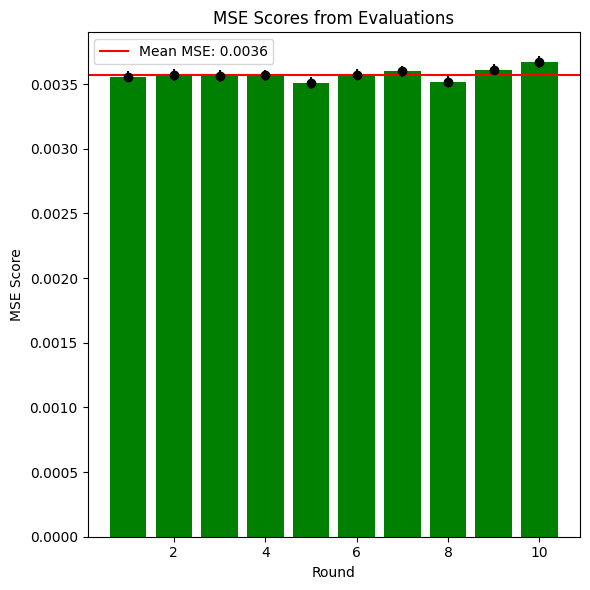

1/1 [==============================] - 0s 92ms/step


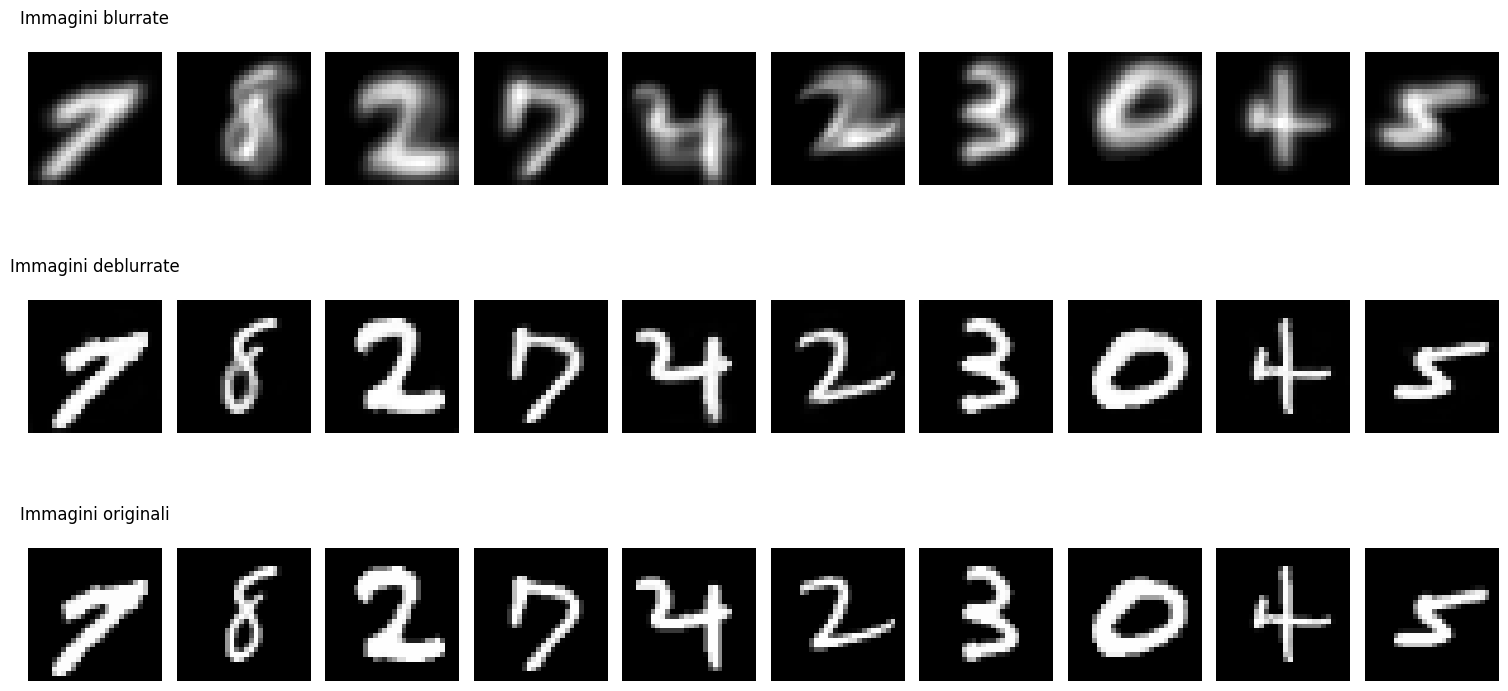

In [188]:
def plot_examples(data_gen, num_examples=10):
    blurred_images, real_images = next(data_gen)
    deblurred_images = model.predict(blurred_images)

    plt.figure(figsize=(15, 8))

    for i in range(num_examples):
        # Plottiamo le immagini blurrate
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(tf.squeeze(blurred_images[i]).numpy(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Immagini blurrate', pad=20)

        # Plottiamo le immagini deblurrate
        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(tf.squeeze(deblurred_images[i]).numpy(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Immagini deblurrate', pad=20)

        # Plotting le immagini originali
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        plt.imshow(tf.squeeze(real_images[i]).numpy(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Immagini originali', pad=20)

    plt.tight_layout()
    plt.show()


# Subplot per MSE
plt.figure(figsize=(6, 6))
plt.bar(range(1, 11), mse_scores, color='green')
plt.errorbar(range(1, 11), mse_scores, yerr=std_mse, fmt='o', color='black')
plt.title('MSE Scores from Evaluations')
plt.xlabel('Round')
plt.ylabel('MSE Score')
plt.axhline(y=mean_mse, color='red', linestyle='-', label=f'Mean MSE: {mean_mse:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Esempi di plot usando il generatore
plot_examples(generator(test_images, 10))

